In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#One Step Ahead Regression
# Original data set retrieved from here:
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

data = pd.read_csv("international-airline-passengers.csv", usecols = [1], engine = "python", skipfooter = 3)
# Print some data rows.
print(data.head())

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121                             


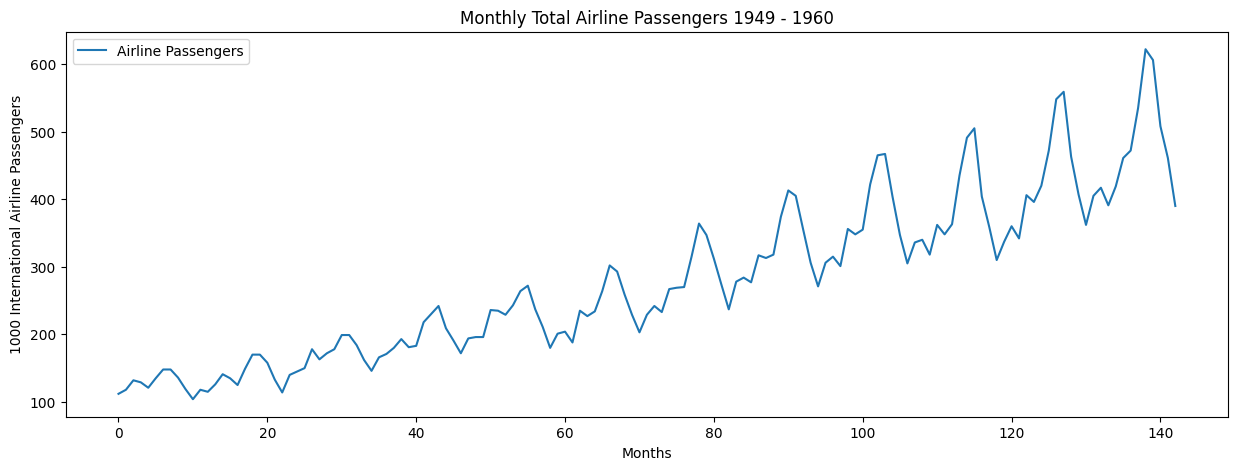

In [3]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

In [6]:
#Build The LSTM Model
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [7]:
#Data preparation
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)
# Print a few values.
dataset[0:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

In [8]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (85, 58)


In [20]:
#Get data into shape to use in Keras
def create_dataset(dataset, window_size = 1):
  data_X, data_Y = [], []
  for i in range(len(dataset) - window_size - 1):
      a = dataset[i:(i + window_size), 0]
      data_X.append(a)
      data_Y.append(dataset[i + window_size, 0])
  return(np.array(data_X), np.array(data_Y))

# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)


Original training data shape:
(83, 1)


In [21]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

New training data shape:
(83, 1, 1)


In [23]:
#LSTM Model
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM(4, input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", optimizer = "adam")
    model.fit(train_X, train_Y, epochs = 100, batch_size = 1, verbose = 2)
    return(model)

In [24]:
# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
83/83 - 2s - loss: 0.0258 - 2s/epoch - 25ms/step
Epoch 2/100
83/83 - 0s - loss: 0.0112 - 136ms/epoch - 2ms/step
Epoch 3/100
83/83 - 0s - loss: 0.0086 - 148ms/epoch - 2ms/step
Epoch 4/100
83/83 - 0s - loss: 0.0081 - 147ms/epoch - 2ms/step
Epoch 5/100
83/83 - 0s - loss: 0.0075 - 148ms/epoch - 2ms/step
Epoch 6/100
83/83 - 0s - loss: 0.0071 - 147ms/epoch - 2ms/step
Epoch 7/100
83/83 - 0s - loss: 0.0064 - 164ms/epoch - 2ms/step
Epoch 8/100
83/83 - 0s - loss: 0.0059 - 184ms/epoch - 2ms/step
Epoch 9/100
83/83 - 0s - loss: 0.0053 - 178ms/epoch - 2ms/step
Epoch 10/100
83/83 - 0s - loss: 0.0049 - 188ms/epoch - 2ms/step
Epoch 11/100
83/83 - 0s - loss: 0.0043 - 167ms/epoch - 2ms/step
Epoch 12/100
83/83 - 0s - loss: 0.0039 - 209ms/epoch - 3ms/step
Epoch 13/100
83/83 - 0s - loss: 0.0035 - 190ms/epoch - 2ms/step
Epoch 14/100
83/83 - 0s - loss: 0.0031 - 189ms/epoch - 2ms/step
Epoch 15/100
83/83 - 0s - loss: 0.0028 - 210ms/epoch - 3ms/step
Epoch 16/100
83/83 - 0s - loss: 0.0026 - 168ms/epoc

In [25]:
#Predictions and Model Evaluation
def predict_and_score(model, X, Y):
  # Make predictions on the original scale of the data.
  pred = scaler.inverse_transform(model.predict(X))
  # Prepare Y data to also be on the original scale for interpretability.
  orig_data = scaler.inverse_transform([Y])
  # Calculate RMSE.
  score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
  return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

2/2 [==============================] - 0s 7ms/step
Training data score: 21.91 RMSE
Test data score: 50.70 RMSE


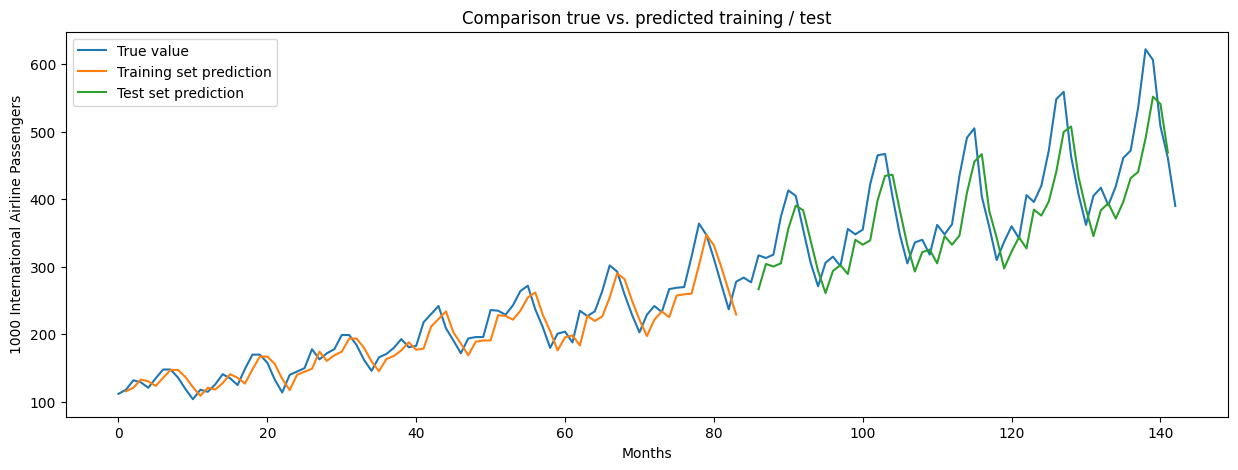

In [26]:
#Plotting original data, predictions, and forecast
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

In [ ]:
!jupyter nbconvert --to html Keras_LSTM_time_series.ipynb